# Table des matières

* [Description du Dataset](#description)
* [Data cleaning](#cleaning)
    - [Travail préliminaire](#travail-preliminaire)
    - [Informations inutiles](#informations-inutiles)
    - [Valeurs manquantes](#valeurs-manquantes)
    - [Ajout d'informations](#ajout-informations)
* [Analyse visuelle](#analyse-visuelle)
    - [Nombre de musee](#nombre-musee)
    - [Tendance générale](#tendance-generale)
    - [Nationalité des musées](#nationalite)
    - [Repartition des musées français](#repartition-musees-france)

In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import geopandas as gpd # Pour créer une map
from geopandas.tools import geocode # Pour retrouver des coordonnées GPS au lieu d'utiliser une API
import folium # Carte interactive
from folium import Marker
from folium.plugins import MarkerCluster, HeatMap # Pour grouper en cluster les musées sur carte interactive

Chaque année est contenue dans un dataset. Nous avons donc 6 datasets dont les colums sont exactement les mêmes.

In [104]:
############# Dataset fréquentation des musées #############
folder_filepath = "../input/frequentationmuseesdefrance20132018"
all_files = glob.glob(folder_filepath + "/*.csv")

liste = []

for filename in all_files:
    annee = pd.read_csv(filename, index_col=None, header=0)
    liste.append(annee)
    
df = pd.concat(liste, axis=0, ignore_index=True)

############# Dataset des communes française #############
communes_francaises = gpd.read_file('../input/communes-francaises-shapes/communes-20210101.shp')

<a id="description"></a>
# Description du dataset

Ce dataset a été trouvé sur le [site du gouvernement](https://www.data.gouv.fr/fr/datasets/frequentation-des-musees-de-france/). Il est découpé en plusieurs fichier csv : un par année.[](http://)

In [105]:
print("Nombre de ligne : ", df.shape[0])
print("Nombre de colonne : ", df.shape[1])

Nombre de ligne :  7138
Nombre de colonne :  22


Aperçu du dataset :

In [106]:
df.head()

,id,osm_id,name,number,street,postal_code,city,country,country_code,status,...,website,phone,fax,year,payant,gratuit,date,tags,description,stats
0,0105302,NaN,Musée Départemental des Pays De l'Ain,NaN,NaN,NaN,BOURG-EN-BRESSE,France,fr,open,...,NaN,NaN,NaN,2018,0.0,0.0,01/02/2003,label:musee de france,NaN,NaN
1,0119201,1.357668e+09,Musée Archéologique,NaN,Place de l'Église,01580,Izernore,France,fr,open,...,NaN,NaN,NaN,2018,1644.0,2174.0,01/02/2003,label:musee de france,NaN,NaN
2,0128301,1.536397e+09,Musée du Peigne et de la Plasturgie,NaN,Rue Capitaine Montreal,01100,Veyziat,France,fr,open,...,NaN,NaN,NaN,2018,1509.0,2397.0,01/02/2003,label:musee de france,NaN,NaN
3,0319002,NaN,Centre National du Costume de Scène et de la S...,NaN,NaN,NaN,MOULINS,France,fr,open,...,NaN,NaN,NaN,2018,72733.0,21431.0,23/10/2009,label:musee de france,NaN,NaN
4,0701001,4.424167e+09,Musée Vivarois César Filhol,15,Rue Jean-Baptiste Bechetoille,07100,Annonay,France,fr,closed,...,NaN,NaN,NaN,2018,0.0,0.0,01/02/2003,label:musee de france,NaN,NaN


<a id="cleaning"></a>
# Cleaning

<a id="travail-preliminaire"></a>
## Travail préliminaire

Un premier travail de data cleaning a été effectué avec un script python car le dataset original présentait un petit coquille : une seule colonne **stat** (données les plus précieuse de ce dataset) était présente avec pour format du "semi-colon separeted file".
Le script remplace toutes les occurences de "payant:" par "", ";gratuit:" par "," et ";label-date:". Lors de ces remplacement, on s'occupe donc de transformer les semi-colons en comma. Enfin, le script remplace "stats" dans le header par "payant,gratuit,date".

<a id="informations-inutiles"></a>
## Informations inutiles

On drop les colonnes de données qui ne nous interessent pas :
- osm_id
- number (N° de rue, ...)
- street
- website
- phone
- fax
- date
- tags
- description

In [107]:
df = df.drop(["osm_id", "number","street","website","phone","fax","date","tags","description","stats"],axis=1)

<a id="valeurs-manquantes"></a>
## Valeurs manquantes

In [108]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

id                 0
name               0
postal_code     1583
city               6
country            0
country_code       0
status             0
lat             1507
lon             1507
year               0
payant             2
gratuit            2
dtype: int64


On élimine toutes les lignes dont la valeur NaN ne peut pas être remplacée ainsi que les musées ayant fait 0 entrée gratuite **ET** 0 entrée payante. On part du principe qu'il est possible qu'un musée soit à 100% gratuit ou payant.

In [109]:
print("Nombre de ligne avant suppression: ", df.shape[0])
df = df[df.id.notna()]
df = df[df.year.notna()]
df = df[df.payant.notna() & df.gratuit.notna()]
df = df[(df.payant != 0.0) | (df.gratuit != 0.0)]
print("Nombre de ligne après suppression : ", df.shape[0])

Nombre de ligne avant suppression:  7138
Nombre de ligne après suppression :  6113


Pour les codes postaux absents, nous les remplaçons grâce à une [API](https://geo.api.gouv.fr) qui transforme un nom de ville en code postal.
Edit: limite de 50 requetes secondes, il serait plus interessant de faire ce processus en même temps que la correction de la colonne stats.

On vérifie le type de donnée qui se trouve dans notre base de donnée :[](http://)

In [110]:
df.dtypes

id               object
name             object
postal_code      object
city             object
country          object
country_code     object
status           object
lat             float64
lon             float64
year              int64
payant          float64
gratuit         float64
dtype: object

Il apparait que l'id est composé du numéro de département. Nous avons donc des lettres pour les musées corse (2A, 2B). Il serait possible de remplacer ces valeurs afin de pouvoir traiter l'id comme une valeur numérique mais je n'en vois pas l'interet pour ce projet.

Cependant, nous allons convertir "payant" et "gratuit" en int.

In [111]:
df.payant = df.payant.astype(int)
df.gratuit = df.gratuit.astype(int)

<a id="ajout-informations"></a>
## Ajout d'informations

Nous allons rajouter une colonne "Total" ayant pour valeur les entrées gratuites additionnées aux payantes :

In [112]:
df['total'] = df.gratuit + df.payant
df.head()

,id,name,postal_code,city,country,country_code,status,lat,lon,year,payant,gratuit,total
1,0119201,Musée Archéologique,01580,Izernore,France,fr,open,46.220134,5.554812,2018,1644,2174,3818
2,0128301,Musée du Peigne et de la Plasturgie,01100,Veyziat,France,fr,open,46.260779,5.646525,2018,1509,2397,3906
3,0319002,Centre National du Costume de Scène et de la S...,NaN,MOULINS,France,fr,open,NaN,NaN,2018,72733,21431,94164
5,0731601,Musée et Site Archéologiques,07130,Soyons,France,fr,open,44.887927,4.850776,2018,12670,2040,14710
6,7428102,Musée du Chablais,74200,Thonon-les-Bains,France,fr,open,46.373593,6.478211,2018,1179,1656,2835


In [113]:
# Fonction utilisant geocode pour recuperer les coordonnées GPS
# Amélioration possible : faire ce travail en amont avec un script Python afin de ne pas répéter
# l'opération à chaque run de ce notebook
def fill_coordinates(row):
    try:
        point = geocode(row, provider='nominatim').geometry.iloc[0] # On prends le premier résultat (pas forcément le bon ...)
        return pd.Series({'Latitude': point.y, 'Longitude': point.x})
    except:
        return None
        
#########################################   A faire en dehors de ce notebook : Unacceptable Use (Nominatim) ##########################################################
# On récupère les index des lignes dont les coordonnées sont manquantes
# en vérifiant que la ville est tout de même spécifiée
#missing_coord = df.index[((df.lat.isnull() | df.lon.isnull()) & df.city.notnull())]
    
#for index in missing_coord:
#    df.loc[index][['lat','lon']] = df.apply(lambda x: fill_coordinates(x['city']), axis=1)
    
#df.head()
# OU
#def my_geocoder(row):
#    point = geocode(row, provider='nominatim').geometry[0]
 #   return pd.Series({'Longitude': point.x, 'Latitude': point.y})
#
#rows_with_missing = df[((df.lat.isnull() | df.lon.isnull()) & df.city.notnull())]
#temp = rows_with_missing.apply(lambda x: my_geocoder(x['city']), axis=1)
#df.update(temp)

<a id="analyse-visuelle"></a>
# Analyse visuelle
<a id="nombre-musee"></a>
## Nombre de musée

In [114]:
nb_musee_par_annee = df.groupby('year').count()['id']
print("Evolution du nombre de musées",nb_musee_par_annee)

Evolution du nombre de musées year
2013    1007
2014    1007
2015     997
2016    1028
2017    1048
2018    1026
Name: id, dtype: int64


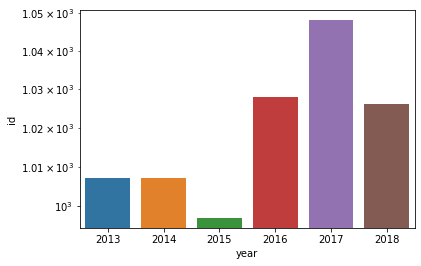

In [115]:
plot_nb_musee = sns.barplot(x=nb_musee_par_annee.index, y=nb_musee_par_annee)
# Je le mets en échelle logarithmique pour avoir une meilleure visibilité 
plot_nb_musee.set_yscale("log")

On remarque qu'il n'y a pas une evolution flagrante du nombre de musée (amplitude de 1048 - 997 = 51, tout de même environ 5% de notre effectif de musées). Nous pourrons donc comparer le nombre d'entrées annuelles par années sans avoir recours à une moyenne en fonction du nombre
<a id="tendance-generale"></a>
## Tendance générale du nombre d'entrée

On va regarder le nombre d'entrée par année :

In [116]:
# On regroupe par année en faisant la somme
somme_par_annee = df.groupby('year').sum()
somme_par_annee = somme_par_annee.drop(['lat','lon'],axis=1)
somme_par_annee

,payant,gratuit,total
year,,,
2013,28502992,35930635,64433627
2014,36650770,28498890,65149660
2015,36244518,26167070,62411588
2016,33913562,26360136,60273698
2017,26332871,37218636,63551507
2018,37692562,28459101,66151663


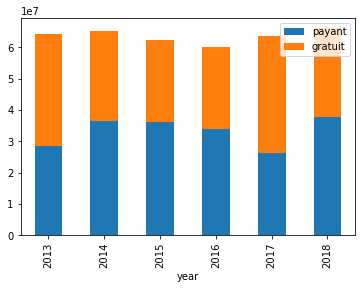

In [117]:
axis = somme_par_annee[["payant", "gratuit"]].plot(kind="bar", stacked=True)

Pas très parlant, puisque d'une année sur l'autre, l'évolution n'est pas très visible. On pourrait utiliser une echelle logarithmique mais on va préfèrer générer un tableau qui présentera les variations en pourcentage d'une année à l'autre.

Voici un tableau qui présente les variations, en pourcentage, par rapport à N-1 :

In [118]:
# fonction anonyme pour calcul (VA-VD)/VD
# shift(1) prends la valeur suivante
evo_somme_par_annee = somme_par_annee.apply(lambda x: ((x - x.shift(1))/x)*100)
# Pour enlever le premier row qui n'a aucune évolution par rapport à N-1
evo_somme_par_annee = evo_somme_par_annee.iloc[1:]
# On arrondi
evo_somme_par_annee = evo_somme_par_annee.round(decimals=2)
evo_somme_par_annee

,payant,gratuit,total
year,,,
2014,22.23,-26.08,1.10
2015,-1.12,-8.91,-4.39
2016,-6.87,0.73,-3.55
2017,-28.79,29.17,5.16
2018,30.14,-30.78,3.93


<AxesSubplot:xlabel='year', ylabel='% par rapport à N-1'>

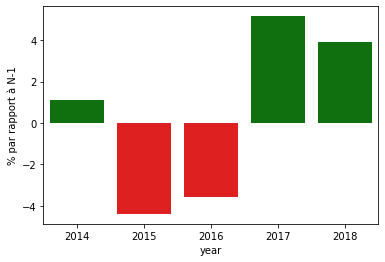

In [119]:
evo_somme_par_annee = evo_somme_par_annee.rename(columns={'total': '% par rapport à N-1'})

# Afin d'avoir les evolutions négatives en rouge et les positives en vert
couleurs = ['green' if (x >= 0) else 'red' for x in evo_somme_par_annee['% par rapport à N-1'] ]
# https://stackoverflow.com/questions/31074758/how-to-set-a-different-color-to-the-largest-bar-in-a-seaborn-barplot

sns.barplot(x=evo_somme_par_annee.index, y=evo_somme_par_annee['% par rapport à N-1'], palette=couleurs)

On lit desormais un peu mieux les évolutions de fréquentation des ces musées.
Ainsi, nous pouvons attribuer cette forte diminution aux attentats de janvier 2015, puis dans une moindre mesure juillet 2016 et à la mise en place du plan vigipirate. Il faut tout de même rappeler qu'il y a 20 musées de moins en 2015 qu'en 2014 et 31 musées de plus en 2016 par rapport à 2015. Il serait intéressant de calculer une moyenne à l'année : nombre total de visiteur / nombre total de musée.
<a id="nationalite"></a>
## Nationalité des musées

In [120]:
nb_musee_pays = df.groupby('country_code').count()['id']
nb_musee_pays

country_code
be      18
fr    6075
ga       3
it       6
us      11
Name: id, dtype: int64

On constate qu'il y a beacoup plus de musée français que d'autres pays.
On ne pourra donc **pas faire d'analyses basées sur les différences entre pays** puisque pas assez d'information.

<a id="repartition-musees-france"></a>
## Répartition des musées français

1199  musées ont été abandonnés car coordonnées manquantes


<AxesSubplot:>

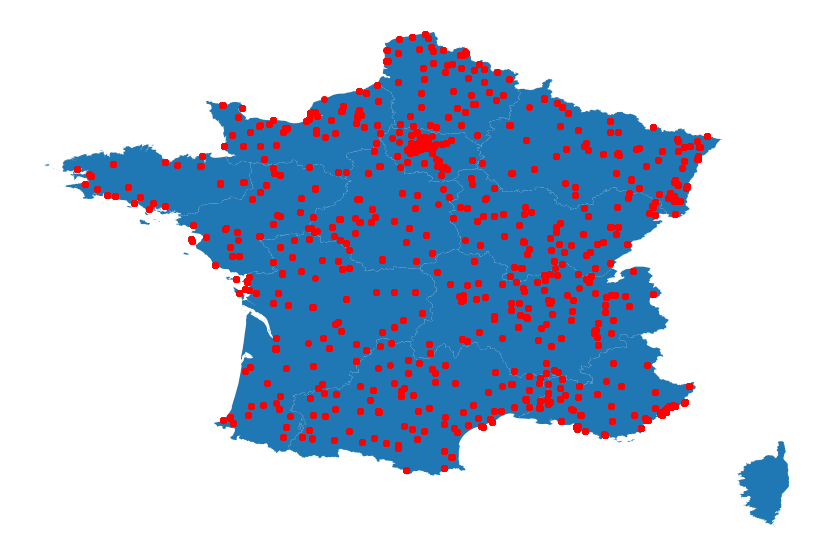

In [121]:
# OpenStreetMap, DGFiP, 2 janvier 2018, sous licence ODbL
france_shape = gpd.read_file("../input/france-shape/regions-20180101.shp")

# On garde uniquement la France métropolitaine
france_shape = france_shape.drop([0,2,7,11,13])
france = france_shape.plot(figsize=(15,10))
france.axis('off')

# Filtrage du dataset pour garder uniquement les musées français METROPOLITAINS
musee_fr = df.loc[df['country_code'] == 'fr']

# On drop les musées aux coordonnées manquantes
print(musee_fr['lat'].isnull().sum(), " musées ont été abandonnés car coordonnées manquantes")
musee_fr = musee_fr.dropna(subset=['lat', 'lon'])

# Étant donné qu'il nous manque quelque code postaux, pour retirer les DOM-TOM, on va se baser sur les coordonées GPS.
# On retiendra uniquement les coordonnées comprisent dans le périmètre 
# de la France métropolitaine, ou plus grossièrement d'un carré autour de la France.
# De façon plus élégante, on aurait pu utiliser le spatial join gpd.sjoin(musee_fr, france)
lat = [42.25, 51.1] # 42.25 => Sud de Perpignan, 51.1 => Nord de Dunkerque
lon = [-5.0, 8.5] # -5 => Ouest de la Bretagne, 8.5 => Est de l'Alsace-Lorraine
musee_fr = musee_fr.loc[(musee_fr.lon > lon[0]) & (musee_fr.lon < lon[1])]
musee_fr = musee_fr.loc[(musee_fr.lat > lat[0]) & (musee_fr.lat < lat[1])]

########################## Diminuer le nombre de point à afficher, inutile  dans notre cas #################################
# A ce stade, si charge de travaille est trop importante, il faut encore réduire le nombre de ligne
# Pour ça, on peut grouper par nom de musée, par code postal, par ville..
# On pourrait se baser sur les deux premiers chiffres du code postal afin de grouper par département,
# mais je vais préferer regrouper les musées proches (en regardant la latitude/longitude).
# Il serait trop couteux de calculer la distance euclidienne entre tous les points pour regrouper les musées les plus proches

# La distance entre chaque degré de latitude, ou longitude, est de 110km
# on va donc arrondir toutes nos coordonnées au dixième inferieur de degré pour regrouper les musées dans un rayons de 11km

## musee_fr['lat'] = musee_fr['lat'].round(1)
## musee_fr['lon'] = musee_fr['lon'].round(1)

## print("Nombre de ligne avant le groupage : ", musee_fr.shape[0])
## musee_fr = musee_fr.groupby(['lat','lon'])
## print("Nombre de ligne après le groupage : ", len(musee_fr))
###########################################################################################################################

# On transforme le dataset pandas en geopandas
gdf = gpd.GeoDataFrame(
    musee_fr, geometry=gpd.points_from_xy(musee_fr.lon, musee_fr.lat))

# On peut dessiner les points
gdf.plot(color='red', ax=france)


Amélioration possible : remplir les coordonnées GPS (lon/lat) de toutes les lignes dont elles sont absentes grâce au nom de la ville.

In [122]:
distinct_musee_fr = musee_fr # pour ne pas afficher 6 fois le même musée (qui apparait une fois par année)
#distinct_musee_fr['name'] = distinct_musee_fr['name'].unique()
distinct_musee_fr = distinct_musee_fr.drop_duplicates(subset=['name'])

carte_interactive = folium.Map(location=[46.23,2.2], zoom_start=6)
HeatMap(data=distinct_musee_fr[['lat', 'lon']], radius=20).add_to(carte_interactive)
# Add points to the map
cluster = MarkerCluster()
for index, row in distinct_musee_fr.iterrows(): # index est inutile mais j'ai une erreur sinon
    cluster.add_child(Marker([row['lat'], row['lon']]))
carte_interactive.add_child(cluster)

Nous constatons que les musées se situent dans les grandes villes, ce qui n'est pas très étonnant.

Etablissons alors un classement des 5 villes ayant le plus de musées : 

Text(0, 0.5, 'Nombre de musée')

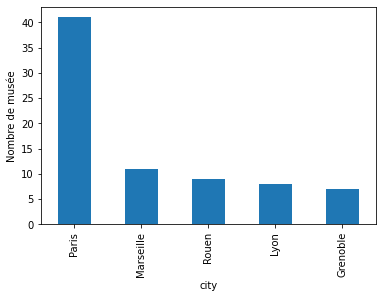

In [123]:
musee_par_ville = distinct_musee_fr.groupby('city').count()['id'].sort_values(ascending = False)
musee_par_ville.head().plot(kind="bar").set_ylabel('Nombre de musée')

Cependant, une grande ville a plus de chance d'avoir une quantité importante de musée.
Nous allons donc faire à nouveau ce classement mais en prenant en compte la superficie de la ville.

In [124]:
# On fait appel à un nouveau dataset
communes_francaises.head()

# On capitalise les noms de ville pour être certain de travailler avec le même format
communes_francaises.nom = communes_francaises['nom'].str.capitalize()
musee_par_ville.city = musee_par_ville.index.str.capitalize() # city est l'index

communes_francaises = communes_francaises.rename(columns={"nom": "city"})

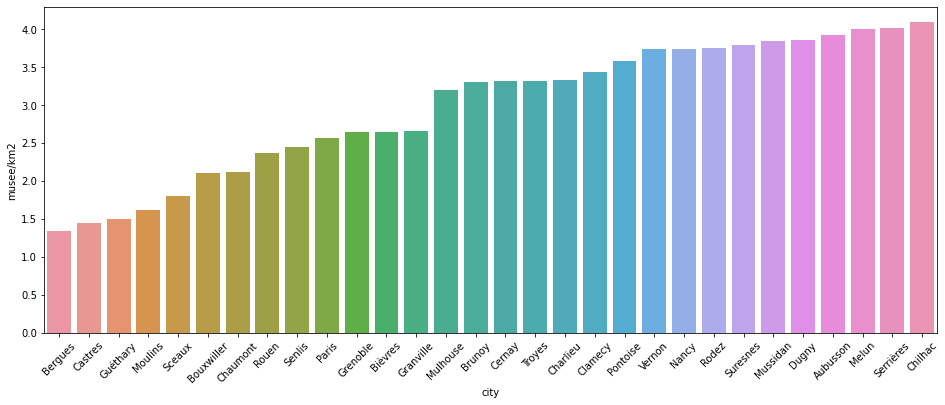

In [155]:
musee_par_ville_superficie = musee_par_ville.to_frame().merge(communes_francaises, on="city")

#musee_par_ville_superficie = communes_francaises.rename(columns={"id": "nb_musee"})
musee_par_ville_superficie = musee_par_ville_superficie.drop(['insee','wikipedia'], axis=1)

# On crée une nouvelle colonne qui présentera le nombre de musée au kilomètre carré
musee_par_ville_superficie['musee/km2'] = (musee_par_ville_superficie.surf_ha / 100) / musee_par_ville_superficie.id

# On trie notre dataframe en fonction
musee_par_ville_superficie = musee_par_ville_superficie.sort_values('musee/km2')

plt.figure(figsize=(16, 6))
ax = sns.barplot(x="city", y="musee/km2",data=musee_par_ville_superficie.head(30))

for item in ax.get_xticklabels():
    item.set_rotation(45)

On constate que le classement a bien changé ! Paris est desormais 21ème de ce classement. Cependant, il y a beaucoup de ville possédant un unique musée, voir deux. 

In [174]:
print(musee_par_ville_superficie['id'].value_counts().head(3))

1    285
2     58
3     16
Name: id, dtype: int64


En effet, il y a 285 villes ayant un unique musée et 58 en possèdent deux.
Afin d'avoir une analyse plus pertinente, nous allons supprimer les villes n'ayant qu'un seul musée.
De plus, nous allons afficher le nombre de musée que possède la ville.

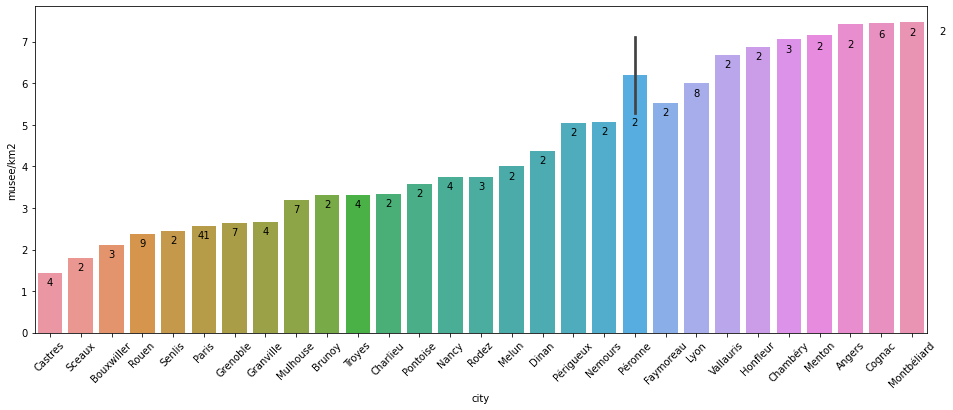

In [205]:
villes_avec_au_moins_2_musees = musee_par_ville_superficie[musee_par_ville_superficie['id'] > 1]

# Trie
villes_avec_au_moins_2_musees = villes_avec_au_moins_2_musees.sort_values('musee/km2')

top_30 = villes_avec_au_moins_2_musees.head(30)
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="city", y="musee/km2",data=top_30)

for item in ax.get_xticklabels():
    item.set_rotation(45)

x = 0
# Pour ajouter le nombre de musée sur la barre
# source : https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
for index, row in top_30.iterrows():
    ax.text(x, row['musee/km2']-0.3, row.id, color='black', ha="center")
    x = x + 1